In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
# start
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self._label = label
        
    def __repr__(self):
        return f"value(data={self.data})"
    
    def __add__(self, other): #called when we add two value objects
        out = Value(self.data + other.data, (self, other),'+')
        # self._op = '+'
        # other._op = '+'
        return out
    
    def __mul__(self, other): #called when we add two value objects
        out = Value(self.data * other.data, (self, other),'*')
        # self._op = '*'
        # other._op = '*'
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,))
        out._op = 'tanh(x)'
        return out

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges



In [31]:
def print_tree(node, level=0, edges=None,):
    if edges is None:
        nodes, edges = trace(node)
    prefix = node._label
    print(" " * (level * 15) + prefix + f" {('('+node._op +')') if node._op else '()'} ---> " + f"(D:{node.data:.4f})  (G:{node.grad:.4f})",end='\n\n')
    state = 0
    for n1, n2 in edges:
        if n2 == node:
            if not state:
                state += 1
                print_tree(n1, level+1,edges)
            else:
                print_tree(n1, level+1,edges)

In [32]:
# l.grad = 1.0
# print_tree(l, 0)

In [52]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1._label = 'x1*w1'
x2w2 = x2*w2; x2w2._label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2._label = 'x1w1x2w2'
n = x1w1x2w2 + b; n._label = 'n'
o = n.tanh()
# print
# print_tree(o, 0)

In [49]:
from graphviz import Digraph

def trace_v2(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace_v2(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n._label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

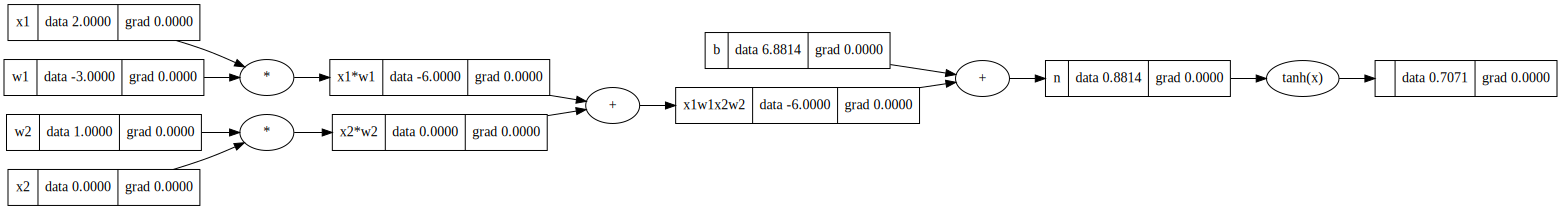

In [51]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1._label = 'x1*w1'
x2w2 = x2*w2; x2w2._label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2._label = 'x1w1x2w2'
n = x1w1x2w2 + b; n._label = 'n'
o = n.tanh()
draw_dot(o)

In [ ]:
# def f(x):
#     return 3*x**2 - 4*x + 5
# f(3.0)
# xs = np.arange(-5,5,0.25)
# ys = f(xs)
# plt.figure(figsize=(5/2,3/2))
# plt.plot(xs, ys)

# h=0.00000001
# x = 2/3
# (f(x+h) - f(x))/h


# a = 2.0
# b = -3.0
# c = 10.0
# d = a*b + c
# print(d)

# h = 0.0001


# a = Value(2.0, label = 'a')
# b = Value(-3.0, label = 'b' )
# c = Value(10.0, label = 'c')

# e = a * b; e._label = 'e'
# d = e + c; d._label = 'd'
# f = Value(-2.0, label = 'f')
# l = d * f; l._label = 'l'
# # print(L)
# nodes, edges = trace(l)
# # print("nodes :",nodes)
# # print("edges :",edges)